# LTV & ROMI
## Панкова Юлия

Источники:

https://medium.com/data-science-at-microsoft/calculating-customer-lifetime-value-a-python-solution-85aa55754b33

https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

https://analytics.productstar.ru/customer-value-6

https://nagornyy.me/courses/data-science/marketing-analysis/

### EDA

Первый важный шаг в работе с любой задачей, связанной с анализом данных - это, собтсвенно, взглянуть на то, что же эти данные собой представляют. Для этого я проведу небольшой эксплораторный анализ.

In [49]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

# задаем "пустые" параметры для визуализации, потом будет докидывать свое
sns.set()

# делаем так, чтобы аутпуты матплотлиба отображались под чанком и сохранялись в ноутбуке
%matplotlib inline

# задаем правильный формат отображения изображений
%config InlineBackend.figure_format = 'svg'

# загружаем данные
df = pd.read_excel("~/notebooks/3605/data.xlsx")

Датасет выглядит следующим образом:

In [50]:
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


5 переменных:
* **product_id**: id продукта, что был приобретен подписчиком. В данном кейсе представляет собой только пробную пподписку на 7 дней.
* **quantity**: количество продуктов, что было приобретено подписчиком. В данном кейсе это каждый раз 1.
* **is_trial_period**: является ли подписка пробной или постоянной. Пробная предоставляется пользователю только одни раз, за нее он не платит, постоянная - обновляется каждую неделю, платная.
* **purchase_date**: дата оформления подписки
* **user_id**: id пользователя, сделавшего заказ

In [51]:
df.shape

(114200, 5)

По этим 5 переменным мы имеем 114200 наблюдений.

In [52]:
pd.DataFrame({
    "Filled share": ((~df.isnull()).sum() / len(df)).round(2),
    "N unique": df.nunique()
}).head()

,Filled share,N unique
product_id,1.0,1
quantity,1.0,1
is_trial_period,1.0,2
purchase_date,1.0,51
user_id,1.0,62909


**Filled share** отвечает за присутствие какого-либо количество недоступных данных в переменной (NaN). Для каждой переменной filled share - 1.0, что значит, что в каждая строка в датасете имеет какое-либо наблюдение по каждой переменной.

**N unique** отвечает за количество уникальных значений внутри переменной. Мы видим, что у "is_trial_period" есть два уникальное состояния (является ли пробным / не является), у **purchase_date** - 51 уникальное состояние (51 уникальных дней, в которых были сделаны заказы), у **user_id** - 62909 уникальных состояние (62909 уникальных пользователей оформило заказы).

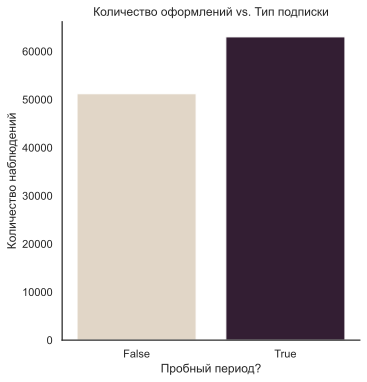

In [53]:
sns.set_style("white")
ax = sns.catplot(x="is_trial_period", kind="count", palette="ch:.25", data=df)
ax.set(xlabel='Пробный период?', ylabel='Количество наблюдений', title = "Количество оформлений vs. Тип подписки")

Мы видим, что большинство оформлений касаются оформления пробной подписки, однако количество оформления подписки еженедельной также довольно велико и обнадеживает нас в отношении развития продукта.

### Текущий LTV

LTV - прибыль, которую приносит клиент за время работы с ним. Для подсчета LTV существует большое количество метрик, подходящее под разные запросы и разные ситуации. Я решила остановиться на этой:


$$ LTV = Margin * APRU * Tenure = ARPU * Tenure $$
* **ARPU** - average revenue per user, прибыль, которую в среднем приносит один пользователь. *APRU = общий доход за весь период / количество пользователей за период* (в нашем случае - каждый день оформления пробного периода);
* **Margin** - валовая прибыль для продукта, выраженная в процентах. *Margin = доход (revenue) - стоимость проданных товаров (cost of goods sold) / доход x 100%*. В данной ситуации нам неизвестен состав cost of goods sold (напр. стоимость затрат на рекламу, зарплату работникам, обучение), поэтому от этой переменной мы избавляемся. Это в свою очередь приводит к тому, что нехитрым образом весь Margin сокращается до 1, и данную метрику мы в анализ не включаем.
* **Tenure** - срок пребывания клиента в сервисе = *1 - с^t / 1 - c*, где c - churn rate, а t - time span, временной горизонт, для которого мы измеряем жизненную ценность клиента. Я выбрала число 2 как пробное для того, чтобы в целом запустить рассчеты и модель в тестовом задании. В дальнейшем с числом можно экспериментировать.

In [54]:
# выниаем из переменной с датой день, в который была оформлена подписка
df['day'] = df['purchase_date'].dt.to_period('D')

# создаем новый датасет, в котором считаем, как много пользователей оформило подписку каждый день
df_grouped = df.groupby(['day'])['user_id'].agg(['size'])

# создаем новый, дублирующий основной, датасет
df_grouped1 = df

# разрешаем питону фильтровать по True / False
pd.options.mode.chained_assignment = None 

# создаем новый датасет, в котором присутствует только оформление еженедельной подписки
df1 = df[df['is_trial_period'] == False]

# выниаем из переменной с датой день, в который была оформлена подписка
df1['day'] = df1['purchase_date'].dt.to_period('D')

# создаем новый датасет, в котором считаем, как много пользователей оформило подписку каждый день
df1_grouped = df1.groupby(['day'])['user_id'].agg(['size'])

# считаем в первом сгруппированном (что станет основным для подсчета) датасете arpu
df_grouped['arpu'] = df1_grouped['size'] * 4.99 / df_grouped['size']

In [55]:
# создаем новый датасет
df2 = df

# выниаем из переменной с датой день, в который была оформлена подписка
df2['day'] = df2['purchase_date'].dt.to_period('D')

# вынимаем когорту, когорта = каждый день, в который оформлялась подписка
df2['cohort'] = df2.groupby('user_id')['purchase_date'] \
                 .transform('min') \
                 .dt.to_period('D') 
# считаем количество пользователей по периодам для когортной таблицы
df_cohort = df2.groupby(['cohort', 'day']) \
              .agg(n_customers=('user_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.day - df_cohort.cohort).apply(attrgetter('n'))

# преобразуем таблицу в pivot-формат для более ясного взаимодействия
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# создаем матрицу retention
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [56]:
# для каждого периода подсчитываем, сколько в срденем в каждой когорте для этого периода остается людей
retention_matrix = retention_matrix.append(retention_matrix.sum(numeric_only=True), ignore_index=True)
k = 49
for i in range(1,49):
    retention_matrix.iloc[51,i] = retention_matrix.iloc[51,i] / (51 - retention_matrix.iloc[:, i].isna().sum())

# подсчитываем tenure по формуле и добавляет в наш освновной датафрейм
retention_matrix = retention_matrix.T 
retention_matrix.index = df_grouped.index
rm = 1 - ((1 - retention_matrix) ** 2)
df_grouped['tenure'] = rm[[51]] / retention_matrix[[51]]

In [57]:
# считаем ltv
df_grouped['ltv'] = df_grouped['arpu'] * df_grouped['tenure']
df_grouped['day'] = df_grouped.index
import numpy as np
# здесь не оказалось значений заказа для расчета и Python выдает na, так что я вставила в пустовавшие клетки среднее значение по Ltv для всех наблюдений
df_grouped.iloc[4,3] = np.mean(df_grouped['ltv'])
df_grouped.iloc[5,3] = np.mean(df_grouped['ltv'])

([], [])

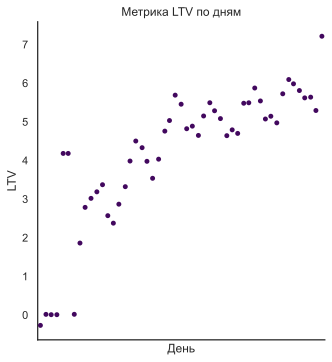

In [58]:
# визуализируем ltv
sns.set_style("white")
ax = sns.catplot(x="day", y = "ltv", color = "#42085e",  data=df_grouped)
ax.set(xlabel='День', ylabel='LTV', title = "Метрика LTV по дням")
# убрала подписи к дате наблюдения вообще, тк даже при поворотах / экспериментами с размером надписи даты все равно накладывадись друг на друга и становились нечитаемыми.
plt.xticks([])

Итак, мы видим, что в нашем случае LTV имеет экспоненциальное распредление, что значит, что при приходе нового пользователя LTV резко растет, затем рост продолжается, но уже с меньшей амплитудой.

### LTV на полгода / кривая

LTV на следующие полгода может быть предсказано с помощью ARIMA-модели предсказания time-serries данных.

Для начала проведем тест автокорреляции - необходимой статистической взаимосвязь между последовательностями величин одного ряда, взятыми со сдвигом по времени (наш кейс!).

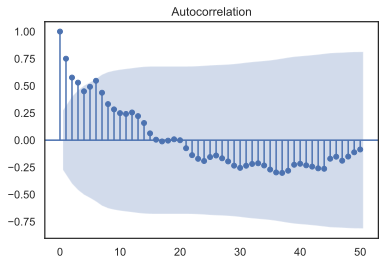

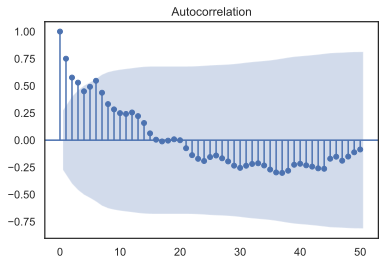

In [59]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_grouped.ltv, lags=50)

Видим, что у нас есть повторяющийся паттерн - ltv всегда немного выше в начале недели, затем немного падает, а затем снова немного поднимается. Теперь предскажем ltv на следующие полгода (180 дней):

In [60]:
ts_ltv = pd.Series(data=df_grouped.ltv.values, index=df_grouped.day.values)

In [61]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_ltv, order=(2,1,1)); # просто модель
model_fit = model.fit()

c:\python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated i

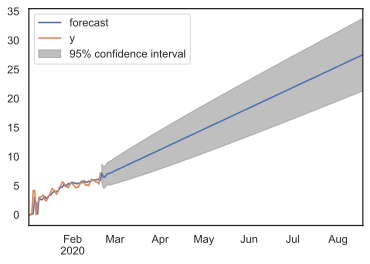

In [62]:
model_fit.plot_predict(end=230);

Таким образом, ltv будет расти (вероятно сохраняя волнообразный паттерн поведения, так как CI довольно широкий), в среднем в прелелах на 5 единиц в месяц.

### ROMI 

ROMI - Return of Marketing Investment, показатель окупаемости.

Рассчитаем по формуле: валовая прибыль - затраты на маркетинг / затраты на маркетинг * 100%

#### На 4 недели:

1) Посчитаем, сколько платящих пользователей пришло за месяц (4 недели):

In [74]:
# создаем новый датасет, в котором присутствует только оформление еженедельной подписки
df1 = df[df['is_trial_period'] == False]

# выниаем из переменной с датой день, в который была оформлена подписка
df1['month'] = df1['purchase_date'].dt.to_period('M')

# создаем новый датасет, в котором считаем, как много пользователей оформило подписку каждый день
df1_grouped = df1.groupby(['month'])['user_id'].agg(['size'])

In [75]:
df1_grouped

,size
month,
2020-01,21137
2020-02,30055


2) Посчитаем, сколько платных подписок оформлено за любые 4 недели в среднем и какую прибыль они принесли:

In [78]:
mean = np.mean(df1_grouped['size']) * 4.99
mean

127724.04000000001

3) Выведем ROMI

In [79]:
(mean - np.mean(df1_grouped['size']) * 6) / (np.mean(df1_grouped['size']) * 6) * 100

-16.83333333333333

Итак, ROMI на 4 недели - отрицательный и составляет -16,8%

#### На полгода (6 месяцев)

В наших данных присутствуют наблюдения по 2 месяцам - возьмем значение по прибыли за эти 2 месяца и умножим на 3, чтобы произвести расчеты, значения по затратам также умножим на 3 и посчитаем ROMI.

In [85]:
profit = sum(df1_grouped['size']) * 3 * 4.99
cost = sum(df1_grouped['size']) * 3 * 6
(profit - cost) / cost * 100

-16.833333333333332

ROMI на полгода также составил - 16,8%.